In [13]:
import functools
import itertools
import multiprocessing as mp

import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import edgedroid.data as e_data
import edgedroid.util as util
from edgedroid.execution_times import *

raw_data_params = e_data.load_default_exec_time_data()
data = preprocess_data(*raw_data_params)
raw_data, *_ = raw_data_params
data

,run_id,seq,neuroticism,impairment,next_exec_time,transition,duration
0,134146,1,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.956,NoTransition,"[0.0, 5.0)"
1,134146,2,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",5.443,NoTransition,"[0.0, 5.0)"
2,134146,3,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",5.206,NoTransition,"[0.0, 5.0)"
3,134146,4,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.783,NoTransition,"[0.0, 5.0)"
4,134146,5,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.760,NoTransition,"[5.0, 10.0)"
...,...,...,...,...,...,...,...
6715,137353,164,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.722,Higher2Lower,"[5.0, 10.0)"
6716,137353,165,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",3.475,Higher2Lower,"[5.0, 10.0)"
6717,137353,166,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.296,Higher2Lower,"[10.0, inf)"
6718,137353,167,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.608,Higher2Lower,"[10.0, inf)"


In [2]:
raw_data

,run_id,seq,exec_time,delay,neuroticism
0,134146,1,4.433,0.0,0.375
1,134146,2,2.956,0.0,0.375
2,134146,3,5.443,0.0,0.375
3,134146,4,5.206,0.0,0.375
4,134146,5,4.783,0.0,0.375
...,...,...,...,...,...
6715,137353,164,6.501,0.0,0.625
6716,137353,165,4.722,0.0,0.625
6717,137353,166,3.475,0.0,0.625
6718,137353,167,2.296,0.0,0.625


In [3]:
# generate data for model

num_traces = 100
run_ids = raw_data.run_id.unique()
run_len = len(raw_data[raw_data.run_id == np.random.choice(run_ids)].index)

results = {}

with mp.Pool() as pool:
    for model_cls in (TheoreticalExecutionTimeModel, EmpiricalExecutionTimeModel):
        # diff_vals = np.empty((len(run_ids), num_traces, run_len))

        diff_vals = pd.DataFrame(
            index=pd.MultiIndex.from_product((run_ids, range(num_traces), range(run_len))),
            columns=['diff']
        )

        model_name = model_cls.__name__

        for participant in tqdm(run_ids, desc=model_name, leave=True):
            # calculate average model deviation wrt to real data
            # by generating num_traces for each experimental run,
            # and then averaging the difference per step

            raw_delays = raw_data[raw_data.run_id == participant].delay
            neuro = raw_data[raw_data.run_id == participant].neuroticism.values[0]
            raw_exec_times = raw_data[raw_data.run_id == participant].exec_time.to_numpy()

            model = model_cls(data=data, neuroticism=neuro)

            for j, trace in enumerate(pool.starmap(
                    util.gen_model_trace,
                    zip(itertools.repeat(raw_delays, num_traces),
                        itertools.repeat(model))
            )):
                trace = (trace[:-1] - raw_exec_times) / raw_exec_times
                diff_vals.loc[pd.IndexSlice[participant, j, :]] = np.atleast_2d(trace).T

            # traces = np.array(pool.starmap(
            #     util.gen_model_trace,
            #     iterable=zip(itertools.repeat(raw_delays, num_traces),
            #                  itertools.repeat(model))
            # ))[:, :-1]  # generated trace has one extra step at the end

            # generate diff wrt real data
            # trace_diff = (traces - raw_exec_times) / raw_exec_times
            # for j, trace in enumerate(trace_diff):
            #     diff_vals.loc[pd.IndexSlice[participant, j, :]] = np.atleast_2d(trace).T

        results[model_name] = diff_vals

TheoreticalExecutionTimeModel:   0%|          | 0/40 [00:00<?, ?it/s]

EmpiricalExecutionTimeModel:   0%|          | 0/40 [00:00<?, ?it/s]

In [34]:
df = pd.DataFrame(index=results[EmpiricalExecutionTimeModel.__name__].index)
for model, diff_vals in results.items():
    print(f'{model} relative to empirical data --- '
          f'mean = {diff_vals.mean().item():0.03f} | '
          f'std = {diff_vals.std().item():0.03f}')
    df[model] = diff_vals

df = df.reset_index() \
    .rename(columns={'level_0': 'run_id', 'level_1': 'trace', 'level_2': 'step'}) \
    .set_index(['run_id', 'trace', 'step'])
df = df.melt(ignore_index=False,
        value_vars=[EmpiricalExecutionTimeModel.__name__, TheoreticalExecutionTimeModel.__name__],
        var_name='model', value_name='exec_time_diff').reset_index()
df

TheoreticalExecutionTimeModel relative to empirical data --- mean = 0.251 | std = 3.364
EmpiricalExecutionTimeModel relative to empirical data --- mean = 0.313 | std = 3.224


,run_id,trace,step,model,exec_time_diff
0,134146,0,0,EmpiricalExecutionTimeModel,0.502369
1,134146,0,1,EmpiricalExecutionTimeModel,1.611637
2,134146,0,2,EmpiricalExecutionTimeModel,-0.043542
3,134146,0,3,EmpiricalExecutionTimeModel,0.129274
4,134146,0,4,EmpiricalExecutionTimeModel,-0.136107
...,...,...,...,...,...
1343995,137353,99,163,TheoreticalExecutionTimeModel,-0.200417
1343996,137353,99,164,TheoreticalExecutionTimeModel,0.859365
1343997,137353,99,165,TheoreticalExecutionTimeModel,0.77407
1343998,137353,99,166,TheoreticalExecutionTimeModel,0.404216


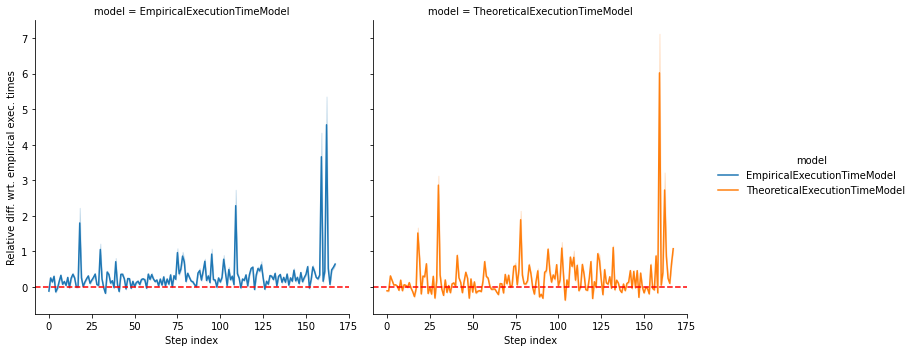

In [42]:
fg = sns.relplot(
    kind='line',
    x='step',
    y='exec_time_diff',
    col='model',
    hue='model',
    data=df
)
fg.set_axis_labels('Step index', 'Relative diff. wrt. empirical exec. times',)
fg.refline(y=0, color='red')
# fg.figure.tight_layout()
fg.figure.savefig('./diff_over_time.png')
plt.show()